Mega-Amp Spherical Tokamak
==========================

An example of a dead start (from scratch) for the MAST tokamak


In [1]:
from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.MAST()

# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.2, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=129, ny=129)        # Number of grid points

Define toroidal current function. The RHS of the Grad-Shafranov equation is determined by the toroidal current density

$j_{tor} = -R\frac{\partial p}{\partial \psi} - \frac{1}{\mu_0 R}f\frac{\partial p}{\partial \psi}$

The profiles can be adjusted to match global constrants, such as the pressure on axis and the total plasma current $I_p$

The toroidal current function jtor_func calculates the toroidal current density $j_{tor}$ given $\psi$ on an R-Z mesh

In [2]:
from freegs.jtor import ConstrainPaxisIp

profiles = ConstrainPaxisIp(1e4, # Plasma pressure on axis [Pascals]
                            1e6, # Plasma current [Amps]
                            0.4) # vacuum f = R*Bt

In [3]:
from freegs import control

xpoints = [(0.6, -1.1),   # (R,Z) locations of X-points
           (0.6, 1.1)]

isoflux = [(0.6,-1.1, 1.4, 0.0),(0.6,1.1, 1.4, 0.0), (0.6,-1.1, 0.25, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

Current changes: [ 11410848.  11419760.   -638808.   -638736.   -585056.   -585656.
   2134808.   2135032.  -8346536.  -8346728.     40802.]


In [4]:
from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             profiles,     # The toroidal current profile function
             constrain,    # Constraint function to set coil currents
             niter=5, sublevels=5, ncycle=3)    # Linear solve settings

Current changes: [  4.03343628e+03  -4.18699741e+03  -3.78482666e+02   2.65857727e+02
   8.61288910e+02  -8.87409088e+02  -4.03022034e+02   4.53606903e+02
  -2.28141785e+02   3.14294891e+02   1.24326229e+00]
Constraints: L = 9.932140e+05, Beta0 = 1.078194e-01
Maximum change in psi: 7.266769e-01. Relative: 4.863592e-02
Current changes: [-10722832.   -10730208.      654480.      654360.      528944.      529528.
  -2164016.    -2164360.     7794856.     7794976.      -40280.25]
Constraints: L = 1.558546e+06, Beta0 = 2.754833e-01
Maximum change in psi: 3.040029e-02. Relative: 3.101915e-02
Current changes: [-73328.375      -65013.8125       5363.75         5754.875       -5231.125
  -3997.125      -42423.5625     -44620.6875      37541.125       35656.25
   1315.88867188]
Constraints: L = 1.648690e+06, Beta0 = 2.270981e-01
Maximum change in psi: 1.488086e-02. Relative: 1.609787e-02
Current changes: [-18161.96875    -19503.625        4886.5625       4108.125       -2223.8125
  -2042.4375   

In [5]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 1.000000e+06 Amps


In [6]:
tokamak.printCurrents()

P2U : Coil(R=0.49,Z=1.76,current=587652.4831542969)
P2L : Coil(R=0.49,Z=-1.76,current=587761.4440002441)
P3U : Coil(R=1.1,Z=1.1,current=31430.853271484375)
P3L : Coil(R=1.1,Z=-1.1,current=31531.00616455078)
P4U : Coil(R=1.51,Z=1.095,current=-64803.10171508789)
P4L : Coil(R=1.51,Z=-1.095,current=-65152.483306884766)
P5U : Coil(R=1.66,Z=0.52,current=-112538.2017211914)
P5L : Coil(R=1.66,Z=-0.52,current=-112432.24856567383)
P6U : Coil(R=1.5,Z=0.9,current=-503730.50897216797)
P6L : Coil(R=1.5,Z=-0.9,current=-503638.6191711426)
P1 : Solenoid(R=0.15,Zmin=-1.0,Zmax=1.0,current=2942.535620689392,N=100)


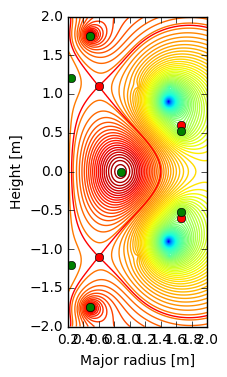

In [7]:
%matplotlib inline

from freegs.plotting import plotEquilibrium
plotEquilibrium(eq)

Modifying the equilibrium
-------------------------

Modify the constraints for the X-point locations and isoflux pairs. Starting from the previous solution, this quie quickly finds a new solution.

Current changes: [  -9224.       -9519.      303481.125   303475.25   -113616.25   -113614.75
  228948.75    228953.875  -484923.     -484928.75      4439.3125]


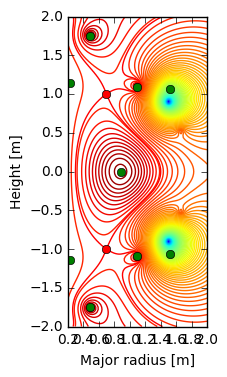

In [8]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = control.constrain(xpoints=xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq)

In [9]:
picard.solve(eq,           # The equilibrium to adjust
             profiles,    # The toroidal current profile function
             constrain,    # Constraint function to set coil currents
             niter=5, sublevels=5, ncycle=3)    # Linear solve settings

Current changes: [ -1.35518845e+02   1.35590286e+02   6.75702286e+00  -5.94100571e+00
  -2.99014282e+01   3.06661377e+01   9.74723625e+00  -1.41455498e+01
   8.06812286e+00  -5.87223816e+00  -5.83782196e-02]
Constraints: L = 1.947252e+06, Beta0 = 1.860013e-01
Maximum change in psi: 1.260151e-02. Relative: 8.283445e-03
Current changes: [  9.37500000e+02   9.62937500e+02  -1.97161406e+04  -1.97158281e+04
   1.12425938e+04   1.12433594e+04  -3.33332031e+04  -3.33362305e+04
   4.42355234e+04   4.42355469e+04  -7.48681641e+00]
Constraints: L = 1.989479e+06, Beta0 = 1.704021e-01
Maximum change in psi: 3.718811e-03. Relative: 2.534997e-03
Current changes: [  172.28125      156.515625   -3755.1640625  -3755.70703125  2302.84375
  2298.171875   -8652.23632812 -8647.8828125   9284.2109375   9288.375
    20.86425781]
Constraints: L = 2.008648e+06, Beta0 = 1.660983e-01
Maximum change in psi: 1.715948e-03. Relative: 1.178451e-03
Current changes: [   42.28125       39.078125    -979.9140625   -978.7

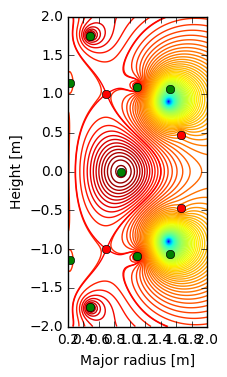

In [10]:
plotEquilibrium(eq)